In [110]:
# A décommenter à la première exécution si jupyter se plaint de ne pas trouver oracledb
!pip install --upgrade oracledb

In [111]:
# Compléter ici les imports dont vous avez besoin, ne pas modifier ceux déjà présents
import getpass
from os import getenv
import pandas as pd
import oracledb
import warnings
import matplotlib.pyplot as plt
import seaborn as sns

In [112]:
# Nécessaire pour éviter les problèmes de session
class Connexion(object):
    def __init__(self, login, password):
        self.conn = oracledb.connect(
            user=login,
            password=password,
            host="oracle.iut-orsay.fr",
            port=1521,
            sid="etudom",
        )
        self.conn.autocommit = False

    def __enter__(self):
        self.conn.autocommit = False
        return self.conn

    def __exit__(self, *args):
        self.conn.close()

In [113]:
# La fonction ci-dessous est à utiliser pour exécuter une requête et stocker les résultats dans un dataframe Pandas sans afficher d’alerte.
# Vous pouvez vous en inspirer pour créer vos propres fonctions.
def requete_vers_dataframe(connexion_data, requete, valeurs = None):
    with Connexion(login=connexion_data['login'], password=connexion_data['password']) as connexion:
        warnings.simplefilter(action='ignore', category=UserWarning)
        if valeurs is not None:
            df = pd.read_sql(requete, connexion, params=valeurs)
        else:
            df = pd.read_sql(requete, connexion)
        warnings.simplefilter("always") 
        return df

In [129]:
# Saisir ci-dessous l'édition des JO qui vous a été attribuée. Cela correspond au LibelleHote dans la table HOTE de la base de données
# Par exemple EDITION_JO = "2020 Summer Olympics"
EDITION_JO = "1948 Summer Olympics"
# Saisir ci-dessous le login court de la base utilisée pour votre carnet
SCHEMA = "EBENOTH"

# TABLEAU DE BORD DES JO

## Partie consultation des données

In [153]:
# On demande à l'utilisateur son login et mot de passe pour pouvoir accéder à la base de données
if getenv("DB_LOGIN") is None:
    login = input("Login : ")
else:
    login = getenv("DB_LOGIN")
if getenv("DB_PASS") is None:
    password = getpass.getpass("Mot de passe : ")
else:
    password = getenv("DB_PASS")
conn = {'login': login, 'password': password}

Login :  ebenoth
Mot de passe :  ········


In [183]:
# On vérifie que l'utilisateur est bien connecté à la base de données, que le schéma est bon, et qu'on trouve la bonne édition des JO
data = requete_vers_dataframe(conn, f"SELECT * FROM {SCHEMA}.HOTE WHERE LibelleHote LIKE (:libelle)",{"libelle":EDITION_JO})
id_hote = int(data.IDHOTE.iloc[0])
print(f"Identifiant de l’hôte : {id_hote}")

Identifiant de l’hôte : 12


### Statistiques de base : participation

#### Nombre de nations participant à ces JO

In [216]:
# Calculer avec une requête et afficher le nombre de nations participant à cette édition
data = requete_vers_dataframe(conn,f""" 
SELECT COUNT(*) AS NBPAYS
FROM (
    SELECT MN.CODENOC
    FROM {SCHEMA}.MEDAILLES_NOC MN
    INNER JOIN {SCHEMA}.EQUIPE EQ ON MN.CODENOC = EQ.NOC
    INNER JOIN {SCHEMA}.PARTICIPATION_EQUIPE PE ON PE.IDEQUIPE = EQ.IDEQUIPE
    INNER JOIN {SCHEMA}.EVENEMENT E ON PE.IDEVENEMENT = E.IDEVENEMENT
    INNER JOIN {SCHEMA}.HOTE H ON E.IDHOTE = H.IDHOTE
    WHERE 
        H.IDHOTE =12

    UNION
    
    SELECT MN.CODENOC
    FROM {SCHEMA}.MEDAILLES_NOC MN
    INNER JOIN {SCHEMA}.PARTICIPATION_INDIVIDUELLE P ON MN.CODENOC = P.NOC
    INNER JOIN {SCHEMA}.EVENEMENT E ON P.IDEVENT = E.IDEVENEMENT
    INNER JOIN {SCHEMA}.HOTE H ON E.IDHOTE = H.IDHOTE
    WHERE 
        H.IDHOTE =12
)""")


nbParticipant = int(data.NBPAYS.iloc[0])
print(f"Le nombre de pays est de : {nbParticipant}")


Le nombre de pays est de : 74


#### Nombre d'athlètes participant à ces JO, répartition par genre et /ou par pays

In [185]:
# Calculer avec une requête et afficher le nombre d’athlètes participant et la répartition par genre et/ou par pays
requete_participation = f"""
SELECT 
    n.CodeNOC,
    COUNT(DISTINCT a.idAthlete) AS nombre_total_athletes,
    COUNT(DISTINCT CASE WHEN a.Genre = 'Female' THEN a.idAthlete END) AS nombre_femmes,
    COUNT(DISTINCT CASE WHEN a.Genre = 'Male' THEN a.idAthlete END) AS nombre_hommes
FROM 
    {SCHEMA}.ATHLETE a
JOIN 
    {SCHEMA}.PARTICIPATION_individuelle pi ON a.idathlete = pi.IdAthlete
JOIN 
    {SCHEMA}.EVENEMENT e ON pi.idEvent = e.IdEvenement
JOIN 
    {SCHEMA}.NOC n ON pi.NOC = n.CodeNOC
JOIN 
    {SCHEMA}.HOTE h ON e.IDHOTE = h.IDHOTE
WHERE 
    h.idHote=12
GROUP BY 
    n.CodeNOC

UNION

SELECT 
    n.CodeNOC,
    COUNT(DISTINCT a.idAthlete) AS nombre_total_athletes,
    COUNT(DISTINCT CASE WHEN a.Genre = 'Female' THEN a.idAthlete END) AS nombre_femmes,
    COUNT(DISTINCT CASE WHEN a.Genre = 'Male' THEN a.idAthlete END) AS nombre_hommes
FROM 
    {SCHEMA}.ATHLETE a
JOIN 
    {SCHEMA}.Composition_Equipe ce ON a.idAthlete = ce.IDAthlete
JOIN 
    {SCHEMA}.EQUIPE e ON ce.IdEquipe = e.IDEquipe
JOIN 
    {SCHEMA}.PARTICIPATION_equipe pe ON e.IdEquipe = pe.IdEquipe
JOIN 
    {SCHEMA}.NOC n ON e.NOC = n.CodeNOC
JOIN 
    {SCHEMA}.HOTE h ON h.codenochote = n.CodeNOC
WHERE 
    h.idHote=12
GROUP BY 
    n.CodeNOC
"""


data_requete_participation = requete_vers_dataframe(conn, requete_participation)

data_requete_participation

,CODENOC,NOMBRE_TOTAL_ATHLETES,NOMBRE_FEMMES,NOMBRE_HOMMES
0,ARG,124,11,113
1,AUS,56,9,47
2,AUT,110,25,85
3,BEL,81,8,73
4,BER,12,2,10
5,BRA,54,11,43
6,CAN,90,21,69
7,CHI,34,4,30
8,CHN,10,1,9
9,COL,7,0,7


### Les médailles décernées lors de ces JO

#### Médailles individuelles (épreuves individuelles)

##### Tableau du TOP 10 individuel

In [186]:
# Récupérer les données, les transformer si nécessaire, puis afficher sous forme de tableau et/ou d'un graphique
data = requete_vers_dataframe(conn,f"""
SELECT
    A.NOMATHLETE,
    A.PRENOMATHLETE,
    SUM(CASE WHEN PI.MEDAILLE = 'Gold' THEN 1 ELSE 0 END) AS MEDAILLES_OR,
    SUM(CASE WHEN PI.MEDAILLE = 'Silver' THEN 1 ELSE 0 END) AS MEDAILLES_ARGENT,
    SUM(CASE WHEN PI.MEDAILLE = 'Bronze' THEN 1 ELSE 0 END) AS MEDAILLES_BRONZE,
    COUNT(PI.MEDAILLE) AS TOTAL_MEDAILLES
FROM
    {SCHEMA}.ATHLETE A
    INNER JOIN {SCHEMA}.PARTICIPATION_INDIVIDUELLE PI ON A.IDATHLETE = PI.IDATHLETE
    INNER JOIN {SCHEMA}.EVENEMENT EV ON PI.IDEVENT = EV.IDEVENEMENT
    INNER JOIN {SCHEMA}.HOTE H ON EV.IDHOTE = H.IDHOTE
WHERE 
    H.IDHOTE = 12
GROUP BY
    A.NOMATHLETE,
    A.PRENOMATHLETE
ORDER BY
    MEDAILLES_OR DESC,
    MEDAILLES_ARGENT DESC,
    MEDAILLES_BRONZE DESC,
    TOTAL_MEDAILLES DESC,
    A.NOMATHLETE,
    A.PRENOMATHLETE
FETCH FIRST 10 ROWS ONLY
""")
data

,NOMATHLETE,PRENOMATHLETE,MEDAILLES_OR,MEDAILLES_ARGENT,MEDAILLES_BRONZE,TOTAL_MEDAILLES
0,Blankers-Koen,Fanny,3,0,0,3
1,Huhtanen,Veikko,2,1,1,4
2,Aaltonen,Paavo,2,0,1,3
3,Ostermeyer,Micheline,2,0,1,3
4,Draves,Vicki,2,0,0,2
5,Fredriksson,Gert,2,0,0,2
6,Curtis,Ann,1,1,0,2
7,Harlan,Bruce,1,1,0,2
8,Harup,Karen Margrethe,1,1,0,2
9,McLane,Jimmy,1,1,0,2


##### Répartition par NOC

In [187]:
# Récupérer les données, les transformer si nécessaire, puis afficher sous forme de tableau et/ou d'un graphique
data = requete_vers_dataframe(conn,f"""
SELECT
    N.CODENOC,
    SUM(CASE WHEN PI.MEDAILLE = 'Gold' THEN 1 ELSE 0 END) AS MEDAILLES_OR,
    SUM(CASE WHEN PI.MEDAILLE = 'Silver' THEN 1 ELSE 0 END) AS MEDAILLES_ARGENT,
    SUM(CASE WHEN PI.MEDAILLE = 'Bronze' THEN 1 ELSE 0 END) AS MEDAILLES_BRONZE,
    COUNT(PI.MEDAILLE) AS TOTAL_MEDAILLES
FROM
    NOC N
    INNER JOIN {SCHEMA}.PARTICIPATION_INDIVIDUELLE PI ON N.CODENOC = PI.NOC
    INNER JOIN {SCHEMA}.EVENEMENT EV ON PI.IDEVENT = EV.IDEVENEMENT
    INNER JOIN {SCHEMA}.HOTE H ON EV.IDHOTE = H.IDHOTE
WHERE
    H.IDHOTE = 12
GROUP BY
    N.CODENOC
    ORDER BY
    MEDAILLES_OR DESC,
    MEDAILLES_ARGENT DESC,
    MEDAILLES_BRONZE DESC,
    TOTAL_MEDAILLES DESC,
    N.CODENOC
""")
data

,CODENOC,MEDAILLES_OR,MEDAILLES_ARGENT,MEDAILLES_BRONZE,TOTAL_MEDAILLES
0,USA,27,25,15,67
1,SWE,14,9,15,38
2,FIN,9,8,4,21
3,HUN,9,2,11,22
4,FRA,7,4,10,21
5,ITA,6,7,8,21
6,TUR,6,4,2,12
7,SUI,5,8,5,18
8,DEN,4,4,6,14
9,NED,4,2,5,11


#### Médailles par équipes (épreuves par équipe)

##### Tableau du TOP 10 par équipe

In [188]:
# Récupérer les données, les transformer si nécessaire, puis afficher sous forme de tableau et/ou d'un graphique
medaillesequipe = f"""
SELECT 
    eq.NomEquipe,
    SUM(CASE WHEN pe.medaille = 'Gold' THEN 1 ELSE 0 END) AS GoldMedals,
    SUM(CASE WHEN pe.medaille = 'Silver' THEN 1 ELSE 0 END) AS SilverMedals,
    SUM(CASE WHEN pe.medaille = 'Bronze' THEN 1 ELSE 0 END) AS BronzeMedals,
    COUNT(pe.medaille) AS TotalMedals
FROM 
    {SCHEMA}.EQUIPE eq
JOIN 
    {SCHEMA}.PARTICIPATION_EQUIPE pe ON eq.IDEQUIPE = pe.IDEQUIPE
JOIN 
    {SCHEMA}.EVENEMENT ev ON pe.IDEVENEMENT = ev.IDEVENEMENT
JOIN 
    {SCHEMA}.HOTE h ON ev.IDHOTE = h.IDHOTE
WHERE 
    h.idHote=12
GROUP BY 
    eq.NomEquipe
ORDER BY 
    TotalMedals DESC
FETCH FIRST 10 ROWS ONLY
"""
#Tableau
data_medaillesequipe = requete_vers_dataframe(conn, medaillesequipe)
data_medaillesequipe



,NOMEQUIPE,GOLDMEDALS,SILVERMEDALS,BRONZEMEDALS,TOTALMEDALS
0,United States,9,2,3,14
1,France,4,2,5,11
2,Italy,3,5,2,10
3,Great Britain,2,5,2,9
4,Denmark,1,4,2,7
5,Sweden,3,1,2,6
6,Hungary,1,3,2,6
7,Netherlands,1,0,3,4
8,Finland,1,0,2,3
9,Czechoslovakia,2,1,0,3


##### Répartition par NOC

   CODENOC  GOLDMEDALS  SILVERMEDALS  BRONZEMEDALS  TOTALMEDALS
0      USA          11             2             4           17
1      FRA           4             2             5           11
2      GBR           3             5             2           10
3      ITA           3             5             2           10
4      SWE           3             2             3            8
5      DEN           1             4             3            8
6      HUN           1             3             2            6
7      NED           1             0             4            5
8      TCH           2             1             0            3
9      SUI           0             3             0            3
10     NOR           1             1             1            3
11     FIN           1             0             2            3
12     MEX           1             0             1            2
13     BEL           1             0             1            2
14     POR           0             1    

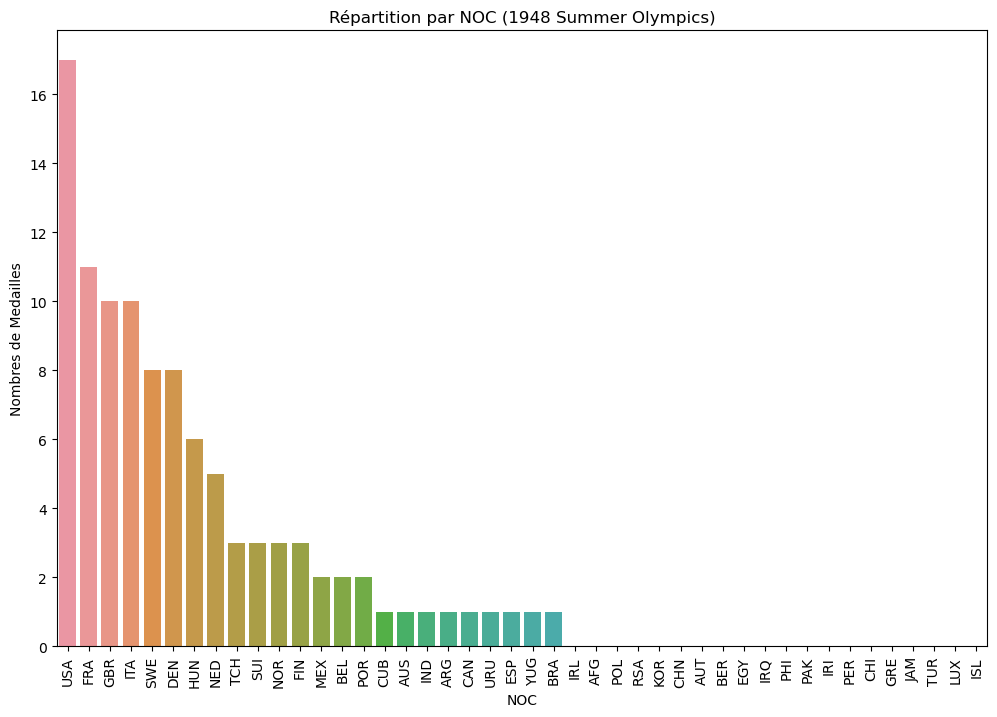

In [189]:
# Récupérer les données, les transformer si nécessaire, puis afficher sous forme de tableau et/ou d'un graphique
requete_medailles_par_noc = f"""
SELECT 
    noc.CodeNOC,
    SUM(CASE WHEN pe.medaille = 'Gold' THEN 1 ELSE 0 END) AS GoldMedals,
    SUM(CASE WHEN pe.medaille = 'Silver' THEN 1 ELSE 0 END) AS SilverMedals,
    SUM(CASE WHEN pe.medaille = 'Bronze' THEN 1 ELSE 0 END) AS BronzeMedals,
    COUNT(pe.medaille) AS TotalMedals
FROM 
    {SCHEMA}.NOC noc
JOIN 
    {SCHEMA}.EQUIPE e ON noc.CodeNOC = e.NOC
JOIN 
    {SCHEMA}.PARTICIPATION_EQUIPE pe ON e.IDEQUIPE = pe.IDEQUIPE
JOIN 
    {SCHEMA}.EVENEMENT ev ON pe.IDEVENEMENT = ev.IDEVENEMENT
JOIN 
    {SCHEMA}.HOTE h ON ev.IDHOTE = h.IDHOTE
WHERE 
    h.idHote=12
GROUP BY 
    noc.CodeNOC
ORDER BY 
    TotalMedals DESC
"""


data_medailles_par_noc = requete_vers_dataframe(conn, requete_medailles_par_noc)
print(data_medailles_par_noc)


#graphe
plt.figure(figsize=(12, 8))
sns.barplot(x='CODENOC', y='TOTALMEDALS', data=data_medailles_par_noc)
plt.title('Répartition par NOC (1948 Summer Olympics)')
plt.xlabel('NOC')
plt.ylabel('Nombres de Medailles')
plt.xticks(rotation=90)
plt.show()

## Partie modification des données

On décide d'ajouter à l'édition des JO étudiée une nouvelle épreuve : le tir à l'arc à poulies. C'est une épreuve de tir à l'arc (*archery*, code `ARC`), qui se fait soit en arc à poulies homme (individuel ou équipe, mais on ne traitera que le cas individuel), soit arc à poulies femmes (individuel ou équipe). Les noms à utiliser pour les événements seront :

- *Compound individual, Men*
- *Compound individual, Women*

Pour simuler les résultats, vous utiliserez les résultats de l'épreuve de [tir à l'arc classique des JO de 2020 en individuel homme](https://www.olympedia.org/results/18000492) en faisant comme s'il s'agissait d'arc à poulies : les athlètes existent déjà dans la base, vous devez maintenant faire en sorte d'ajouter à la base les différents résultats.

Avant de réaliser les modifications, affichez le tableau des médailles individuelles pour l'Italie

In [190]:
# On donne ici l'exemple de comment ajouter un événement. On a stocké dans id_hote l'identifiant des JO sur lesquels on travaille
with Connexion(login=conn['login'], password=conn['password']) as connexion:  # Démarre une nouvelle connexion
    # On démarre une nouvelle transaction
    connexion.begin()
    # On ouvre un curseur, qui est une sorte de pointeur vers une table de résultats
    curseur = connexion.cursor()
    # On passe la requête paramétrée et les paramètres (s'il y en a) au curseur
    curseur.execute(f"SELECT MAX(IDEVENEMENT) FROM {SCHEMA}.EVENEMENT")
    # S'il n'y a pas d'erreur, on peut demander à récupérer les résultats : 
    # - curseur.fetchone() récupère la ligne sur laquelle pointe le curseur, renvoie le résultat sous forme de tuple, et avance à la ligne suivante (si elle existe)
    # - curseur.fetchall() boucle sur toutes les lignes restantes et renvoie une liste de tuples, ou une liste vide s'il n'y a plus de résultats
    # - curseur.fetchmany(nb) renvoie les résultats des nb lignes suivantes sous forme de liste de tuples
    idev = curseur.fetchone()[0]  # Renvoie un tuple, on veut le premier élément du tuple
    idev += 1
    curseur.execute(f"INSERT INTO {SCHEMA}.EVENEMENT VALUES(:idev, :nomev, :statutev, :codedisc, :idhote)", {'idev': idev, 'nomev': 'Compound Individual, Men', 'statutev': 'Olympic', 'codedisc': 'ARC', 'idhote': id_hote})
    connexion.rollback()  # On annule, ce qui est au dessus est pour l'exemple, vous devrez utiliser commit() pour valider la transaction.

In [191]:
# Afficher le tableau des médailles individuelles de l'Italie
requete_medailles_italie = f"""
SELECT 
    a.NomAthlete, 
    a.prenomathlete,
    e.NomEvenement, 
    pi.Medaille
FROM 
    {SCHEMA}.athlete a
JOIN 
    {SCHEMA}.PARTICIPATION_individuelle pi ON pi.idathlete = a.idAthlete
JOIN 
    {SCHEMA}.EVENEMENT e ON pi.idEvent = e.idEvenement
JOIN 
    {SCHEMA}.HOTE h ON e.IDHOTE = h.IDHOTE
WHERE 
    h.idHote=12
    AND NOC = 'ITA' 
    AND pi.Medaille IS NOT NULL
"""


data_medailles_italie = requete_vers_dataframe(conn, requete_medailles_italie)

print("Tableau des médailles individuelles pour l'Italie avant modifications :")
data_medailles_italie

Tableau des médailles individuelles pour l'Italie avant modifications :


,NOMATHLETE,PRENOMATHLETE,NOMEVENEMENT,MEDAILLE
0,Tosi,Giuseppe,"Discus Throw, Men",Silver
1,Piccinini,Amelia,"Shot Put, Women",Silver
2,Cordiale-Gentile,Edera,"Discus Throw, Women",Silver
3,Bandinelli,Spartaco,"Flyweight, Men",Silver
4,Zuddas,Gianni,"Bantamweight, Men",Silver
5,Formenti,Ernesto,"Featherweight, Men",Gold
6,D'Ottavio,Alessandro,"Welterweight, Men",Bronze
7,Fontana,Ivano,"Middleweight, Men",Bronze
8,Ghella,Mario,"Sprint, Men",Gold
9,Cantone,Gino,"Épée, Individual, Men",Gold


### Qualifications [Bonus]

Le round de qualifications en tir à l'arc à poulie est assez similaire au tir à l'arc classique, avec comme différence qu'il n'y a pas de "X", ils comptent comme des 10 pour départager. En utilisant le tableau des résultats de qualifications, faites en sorte que votre tableau de bord insère les données dans la base puis les affiche.

In [43]:
# Faire ici l'insertion des données


In [ ]:
# Faire ici l'affichage du tableau de résultat des qualifications

### Première manche [Bonus]

Faire de même ici avec les résultats de la première manche. Pour simplifier, on considérera que les scores sont identiques à ceux en arc classique.

In [ ]:
# Faire ici l'insertion des données

In [ ]:
# Faire ici l'affichage du tableau de résultat de la première manche

### Deuxième manche [Bonus]

Faire de même ici avec les résultats de la deuxième manche. Pour simplifier, on considérera que les scores sont identiques à ceux en arc classique.

In [ ]:
# Faire ici l'insertion des données

In [ ]:
# Faire ici l'affichage du tableau de résultat de la deuxième manche

### Troisième manche [Bonus]

Faire de même ici avec les résultats de la troisième manche. Pour simplifier, on considérera que les scores sont identiques à ceux en arc classique.

In [ ]:
# Faire ici l'insertion des données

In [ ]:
# Faire ici l'affichage du tableau de résultat de la troisième manche

### Quarts de finale [Bonus]

Faire de même ici avec les résultats des quarts de finale. Pour simplifier, on considérera que les scores sont identiques à ceux en arc classique.

In [ ]:
# Faire ici l'insertion des données

In [ ]:
# Faire ici l'affichage du tableau de résultat des quarts de finale

### Demi-finales [Bonus]

Faire de même ici avec les résultats des demies-finales. Pour simplifier, on considérera que les scores sont identiques à ceux en arc classique.

In [ ]:
# Faire ici l'insertion des données

In [ ]:
# Faire ici l'affichage du tableau de résultat des demies-finales

### Finale [Bonus]

Faire de même ici avec les résultats de la finale. Pour simplifier, on considérera que les scores sont identiques à ceux en arc classique.

In [ ]:
# Faire ici l'insertion des données

In [ ]:
# Faire ici l'affichage du tableau de résultat de la finale

### Résultats des médailles

Pour terminer, saisir les résultats des médailles

In [192]:
# On donne ici l'exemple de comment ajouter un événement. On a stocké dans id_hote l'identifiant des JO sur lesquels on travaille
with Connexion(login=conn['login'], password=conn['password']) as connexion:  # Démarre une nouvelle connexion
    # On démarre une nouvelle transaction
    connexion.begin()
    # On ouvre un curseur, qui est une sorte de pointeur vers une table de résultats
    curseur = connexion.cursor()
    
    insertion_evenement = f"INSERT INTO {SCHEMA}.EVENEMENT VALUES(:idev, :nomev, :statutev, :codedisc, :idhote)"
    
    insertion_resultats = f"INSERT INTO {SCHEMA}.PARTICIPATION_INDIVIDUELLE VALUES(:ida, :idev, :resultat, :medaille, :noc)"
    
    evenements = [
    {'nomev': 'Compound Individual, Women'},
    {'nomev': 'Compound Individual, Men'}
    ]
    
    resultats = [
    {'prenomA' : 'Mete', 'nomA' : 'Gazoz', 'resultat' : '1', 'medaille' : 'Gold', 'noc' : 'TUR'},
    {'prenomA' : 'Mauro', 'nomA' : 'Nespoli', 'resultat' : '2', 'medaille' : 'Silver', 'noc' : 'ITA'},
    {'prenomA' : 'Takaharu', 'nomA' : 'Furukawa', 'resultat' : '3', 'medaille' : 'Bronze', 'noc' : 'JPN'},
    {'prenomA' : 'Tang', 'nomA' : 'Chih-Chun', 'resultat' : '4', 'medaille' : None, 'noc' : 'TPE'},
    {'prenomA' : 'Kim', 'nomA' : 'Wu-Jin', 'resultat' : '5', 'medaille' : None, 'noc' : 'KOR'},
    {'prenomA' : 'Florian', 'nomA' : 'Unruh', 'resultat' : '6', 'medaille' : None, 'noc' : 'GER'},
    {'prenomA' : 'Brady', 'nomA' : 'Ellison', 'resultat' : '7', 'medaille' : None, 'noc' : 'USA'},
    {'prenomA' : 'Li', 'nomA' : 'Jialun', 'resultat' : '8', 'medaille' : None, 'noc' : 'CHN'},
    {'prenomA' : 'Ilfat', 'nomA' : 'Abdullin', 'resultat' : '=9', 'medaille' : None, 'noc' : 'KAZ'},
    {'prenomA' : 'Marcus', 'nomA' : 'D’Almeida', 'resultat' : '=9', 'medaille' : None, 'noc' : 'BRA'},
    {'prenomA' : 'Atanu', 'nomA' : 'Das', 'resultat' : '=9', 'medaille' : None, 'noc' : 'IND'},
    {'prenomA' : 'Crispin', 'nomA' : 'Duenas', 'resultat' : '=9', 'medaille' : None, 'noc' : 'CAN'},
    {'prenomA' : 'Khairul Anuar', 'nomA' : 'Bin Mohamad', 'resultat' : '=9', 'medaille' : None, 'noc' : 'MAS'},
    {'prenomA' : 'Itay', 'nomA' : 'Shanny', 'resultat' : '=9', 'medaille' : None, 'noc' : 'ISR'},
    {'prenomA' : 'Taylor', 'nomA' : 'Worth', 'resultat' : '=9', 'medaille' : None, 'noc' : 'AUS'},
    {'prenomA' : 'Jacob', 'nomA' : 'Wukie', 'resultat' : '=9', 'medaille' : None, 'noc' : 'USA'},
    {'prenomA' : 'Gijs', 'nomA' : 'Broeksma', 'resultat' : '=17', 'medaille' : None, 'noc' : 'NED'},
    {'prenomA' : 'Jarno', 'nomA' : 'De Smedt', 'resultat' : '=17', 'medaille' : None, 'noc' : 'BEL'},
    {'prenomA' : 'Denis', 'nomA' : 'Gankin', 'resultat' : '=17', 'medaille' : None, 'noc' : 'KAZ'},
    {'prenomA' : 'Pravin', 'nomA' : 'Jadhav', 'resultat' : '=17', 'medaille' : None, 'noc' : 'IND'},
    {'prenomA' : 'Kim', 'nomA' : 'Je-Deok', 'resultat' : '=17', 'medaille' : None, 'noc' : 'KOR'},
    {'prenomA' : 'Oh', 'nomA' : 'Jin-Hyeok', 'resultat' : '=17', 'medaille' : None, 'noc' : 'KOR'},
    {'prenomA' : 'Pierre', 'nomA' : 'Plihon', 'resultat' : '=17', 'medaille' : None, 'noc' : 'FRA'},
    {'prenomA' : 'Tarundeep', 'nomA' : 'Rai', 'resultat' : '=17', 'medaille' : None, 'noc' : 'IND'},
    {'prenomA' : 'Riau Ega Agata', 'nomA' : 'Salsabilla', 'resultat' : '=17', 'medaille' : None, 'noc' : 'INA'},
    {'prenomA' : 'Mohammed Ruman', 'nomA' : 'Shana', 'resultat' : '=17', 'medaille' : None, 'noc' : 'BAN'},
    {'prenomA' : 'Ryan', 'nomA' : 'Tyack', 'resultat' : '=17', 'medaille' : None, 'noc' : 'AUS'},
    {'prenomA' : 'Sjef', 'nomA' : 'van den Berg', 'resultat' : '=17', 'medaille' : None, 'noc' : 'NED'},
    {'prenomA' : 'Wang', 'nomA' : 'Dapeng', 'resultat' : '=17', 'medaille' : None, 'noc' : 'CHN'},
    {'prenomA' : 'Wei', 'nomA' : 'Chun-Heng', 'resultat' : '=17', 'medaille' : None, 'noc' : 'TPE'},
    {'prenomA' : 'Wei', 'nomA' : 'Shaoxuan', 'resultat' : '=17', 'medaille' : None, 'noc' : 'CHN'},
    {'prenomA' : 'Steve', 'nomA' : 'Wijler', 'resultat' : '=17', 'medaille' : None, 'noc' : 'NED'},
    {'prenomA' : 'Andrés', 'nomA' : 'Aguilar', 'resultat' : '=33', 'medaille' : None, 'noc' : 'CHI'},
    {'prenomA' : 'Luis', 'nomA' : 'Álvarez', 'resultat' : '=33', 'medaille' : None, 'noc' : 'MEX'},
    {'prenomA' : 'Baatarkhuyag', 'nomA' : 'Otgonbold', 'resultat' : '=33', 'medaille' : None, 'noc' : 'MGL'},
    {'prenomA' : 'Mátyás', 'nomA' : 'Balogh', 'resultat' : '=33', 'medaille' : None, 'noc' : 'HUN'},
    {'prenomA' : 'Dave', 'nomA' : 'Barnes', 'resultat' : '=33', 'medaille' : None, 'noc' : 'AUS'},
    {'prenomA' : 'Galsan', 'nomA' : 'Bazarzhapov', 'resultat' : '=33', 'medaille' : None, 'noc' : 'ROC'},
    {'prenomA' : 'Daniel', 'nomA' : 'Castro', 'resultat' : '=33', 'medaille' : None, 'noc' : 'ESP'},
    {'prenomA' : 'Thomas', 'nomA' : 'Chirault', 'resultat' : '=33', 'medaille' : None, 'noc' : 'FRA'},
    #{'prenomA' : 'Nicholas', 'nomA' : 'D''Amour', 'resultat' : '=33', 'medaille' : None, 'noc' : 'ISV'},
    {'prenomA' : 'Areneo', 'nomA' : 'David', 'resultat' : '=33', 'medaille' : None, 'noc' : 'MAW'},
    {'prenomA' : 'Deng', 'nomA' : 'Yu-Cheng', 'resultat' : '=33', 'medaille' : None, 'noc' : 'TPE'},
    {'prenomA' : 'Arif Dwi', 'nomA' : 'Pangestu', 'resultat' : '=33', 'medaille' : None, 'noc' : 'INA'},
    {'prenomA' : 'Tom', 'nomA' : 'Hall', 'resultat' : '=33', 'medaille' : None, 'noc' : 'GBR'},
    {'prenomA' : 'Mohamed', 'nomA' : 'Hammed', 'resultat' : '=33', 'medaille' : None, 'noc' : 'TUN'},
    {'prenomA' : 'Jeff', 'nomA' : 'Henckels', 'resultat' : '=33', 'medaille' : None, 'noc' : 'LUX'},
    {'prenomA' : 'Oleksiy', 'nomA' : 'Hunbin', 'resultat' : '=33', 'medaille' : None, 'noc' : 'UKR'},
    {'prenomA' : 'Patrick', 'nomA' : 'Huston', 'resultat' : '=33', 'medaille' : None, 'noc' : 'GBR'},
    {'prenomA' : 'Yuki', 'nomA' : 'Kawata', 'resultat' : '=33', 'medaille' : None, 'noc' : 'JPN'},
    {'prenomA' : 'Sanzhar', 'nomA' : 'Musayev', 'resultat' : '=33', 'medaille' : None, 'noc' : 'KAZ'},
    {'prenomA' : 'Hiroki', 'nomA' : 'Muto', 'resultat' : '=33', 'medaille' : None, 'noc' : 'JPN'},
    #{'prenomA' : 'Sławomir', 'nomA' : 'Napłoszek', 'resultat' : '=33', 'medaille' : None, 'noc' : 'POL'},
    #{'prenomA' : 'Nguyễn Hoàng Phi', 'nomA' : 'Vũ', 'resultat' : '=33', 'medaille' : None, 'noc' : 'VIE'},
    {'prenomA' : 'Dan', 'nomA' : 'Olaru', 'resultat' : '=33', 'medaille' : None, 'noc' : 'MDA'},
    {'prenomA' : 'Daniel', 'nomA' : 'Pineda', 'resultat' : '=33', 'medaille' : None, 'noc' : 'COL'},
    {'prenomA' : 'Alviyanto', 'nomA' : 'Prastyadi', 'resultat' : '=33', 'medaille' : None, 'noc' : 'INA'},
    {'prenomA' : 'Žiga', 'nomA' : 'Ravnikar', 'resultat' : '=33', 'medaille' : None, 'noc' : 'SLO'},
    {'prenomA' : 'Youssof', 'nomA' : 'Tolba', 'resultat' : '=33', 'medaille' : None, 'noc' : 'EGY'},
    {'prenomA' : 'Jean-Charles', 'nomA' : 'Valladont', 'resultat' : '=33', 'medaille' : None, 'noc' : 'FRA'},
    {'prenomA' : 'Milad', 'nomA' : 'Vaziri', 'resultat' : '=33', 'medaille' : None, 'noc' : 'IRI'},
    {'prenomA' : 'Antti', 'nomA' : 'Vikström', 'resultat' : '=33', 'medaille' : None, 'noc' : 'FIN'},
    {'prenomA' : 'Jack', 'nomA' : 'Williams', 'resultat' : '=33', 'medaille' : None, 'noc' : 'USA'},
    {'prenomA' : 'James', 'nomA' : 'Woodgate', 'resultat' : '=33', 'medaille' : None, 'noc' : 'GBR'}
    ]

    for event in evenements:
        curseur.execute(f"SELECT MAX(IDEVENEMENT) FROM {SCHEMA}.EVENEMENT")
        idev = curseur.fetchone()[0]  # Renvoie un tuple, on veut le premier élément du tuple
        idev += 1
        curseur.execute(insertion_evenement, {'idev': idev, 'nomev': event['nomev'], 'statutev': 'Olympic', 'codedisc': 'ARC', 'idhote': id_hote}) 
    for result in resultats:
        curseur.execute(f"SELECT MAX(IDEVENEMENT) FROM {SCHEMA}.EVENEMENT")
        
        idev = curseur.fetchone()[0]  # Renvoie un tuple, on veut le premier élément du tuple
        curseur.execute(f"SELECT idAthlete FROM {SCHEMA}.ATHLETE WHERE Nomathlete = :nomA AND PrenomAthlete = :prenomA",{'nomA': result['nomA'], 'prenomA': result['prenomA']})
        ida = curseur.fetchone()[0]
        curseur.execute(insertion_resultats, {'ida': ida, 'idev': idev, 'resultat' : result['resultat'], 'medaille' :result['medaille'], 'noc' :result['noc']})
    
    connexion.commit()  # On annule, ce qui est au dessus est pour l'exemple, vous devrez utiliser commit() pour valider la transaction.
    print("Tout à été mis à jours")

Tout à été mis à jours


## Vérification

Afficher le tableau des médailles de l'Italie après les ajouts de la nouvelle épreuve.

In [203]:
# Affichage du tableau (cf. début de la partie modification)
requete_medailles_italie = f"""
SELECT 
    a.NomAthlete, 
    a.prenomathlete,
    e.NomEvenement, 
    pi.Medaille
FROM 
    {SCHEMA}.athlete a
JOIN 
    {SCHEMA}.PARTICIPATION_individuelle pi ON pi.idathlete = a.idAthlete
JOIN 
    {SCHEMA}.EVENEMENT e ON pi.idEvent = e.idEvenement
JOIN 
    {SCHEMA}.HOTE h ON e.IDHOTE = h.IDHOTE
WHERE 
    h.idHote=12
    AND NOC = 'ITA' 
    AND pi.Medaille IS NOT NULL
"""


data_medailles_italie = requete_vers_dataframe(conn, requete_medailles_italie)

print("Tableau des médailles individuelles pour l'Italie avant modifications :")
data_medailles_italie

Tableau des médailles individuelles pour l'Italie avant modifications :


,NOMATHLETE,PRENOMATHLETE,NOMEVENEMENT,MEDAILLE
0,Tosi,Giuseppe,"Discus Throw, Men",Silver
1,Piccinini,Amelia,"Shot Put, Women",Silver
2,Cordiale-Gentile,Edera,"Discus Throw, Women",Silver
3,Bandinelli,Spartaco,"Flyweight, Men",Silver
4,Zuddas,Gianni,"Bantamweight, Men",Silver
5,Formenti,Ernesto,"Featherweight, Men",Gold
6,D'Ottavio,Alessandro,"Welterweight, Men",Bronze
7,Fontana,Ivano,"Middleweight, Men",Bronze
8,Ghella,Mario,"Sprint, Men",Gold
9,Cantone,Gino,"Épée, Individual, Men",Gold


### Nettoyage

Supprimez maintenant tous les ajouts précédents (médailles, résultats détaillés, nouvelles épreuves) de votre base.

In [219]:
# Nettoyage (avec des requêtes DELETE)
with Connexion(login=conn['login'], password=conn['password']) as connexion:  
    connexion.begin()
    curseur = connexion.cursor()
    requete_Delete1 = f"""
    DELETE FROM {SCHEMA}.PARTICIPATION_INDIVIDUELLE PI
    WHERE PI.IDEVENT IN (SELECT E.IDEVENEMENT
                         FROM {SCHEMA}.EVENEMENT E
                         WHERE E.IDHOTE = 12
                           AND E.NOMEVENEMENT LIKE 'Compound Individual%')
    """

    requete_Delete2 = f"""
    DELETE FROM {SCHEMA}.EVENEMENT WHERE IDHOTE = 12 AND NOMEVENEMENT LIKE 'Compound Individual%'
    """
    curseur.execute(requete_Delete1)
    curseur.execute(requete_Delete2)
    print("Tout a bien été supprimé ")


Tout a bien été supprimé 
